In [ ]:
###
    # This code is about the scatterplots of the seasonal sensitivity of frozen ground area versus the permafrost area sensitivity
    # under climate change for the upper 1.6 m, 2.4 m and 3.2 m ground for CMIP6 model ensemble. 
    # The permafrost area sensitivity under climate change represents the percentage of loss relative to the baseline period (1982–2014) per degree of global warming, 
    # evaluated at 1.5°C, 2.0°C, and 3.0°C warming levels above the pre-industrial period (1850-1900), under the SSP5-8.5 scenario.
    # Permafrost sensitivity to global warming is read from "../Data/Permafrost_sensitivity/",calculated from "../Process/04*.py".
    # Calculate the seasonal sensitivity of frozen ground area.  
    # Exclude MIROC models compared with Figure 2.
    # Output: Figrue S4.
###

In [1]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import xarray as xr
from statsmodels.formula.api import ols
from scipy.stats import pearsonr
import string
import glob
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

In [2]:
def area_weight_mean(data2D, lat, lon):
    """
    Calculate the area-weighted mean of 2D data, accounting for grid cell areas.
    
    Parameters:
    data2D: ndarray
        Variable for area-weighted averaging, with shape [lat, lon].
    lat: ndarray
        Latitude array, 1D, in degrees.
    lon: ndarray
        Longitude array, 1D, in degrees.
    
    Returns:
    float
        Area-weighted mean of the data.
    """
    # Convert latitude to radians
    rad = np.pi / 180.0
    lat_rad = lat * rad

    # Calculate latitude and longitude resolution
    re = 6371220.0  # Earth radius (in meters)
    dlon = np.abs(lon[1] - lon[0]) * rad  # Longitude resolution (in radians)
    dlat = np.abs(lat[1] - lat[0]) * rad  # Latitude resolution (in radians)

    # Calculate the area of each grid cell
    sin_lat1 = np.sin(lat_rad + dlat / 2)
    sin_lat2 = np.sin(lat_rad - dlat / 2)
    grid_areas = (re ** 2) * dlon * (sin_lat1 - sin_lat2)[:, np.newaxis]  # (lat, lon)

    # Calculate weighted mean
    valid_mask = ~np.isnan(data2D)  # Valid data mask
    weighted_sum = np.nansum(data2D * grid_areas * valid_mask)  # Sum of weighted values
    total_weight = np.nansum(grid_areas * valid_mask)  # Sum of weights

    # If total weight is 0 (all NaN), return NaN
    if total_weight == 0:
        return np.nan

    return weighted_sum / total_weight

In [14]:
# Constants
LETTERS = list(string.ascii_lowercase)
depths = ["1.6m", "2.4m", "3.2m"]
MARKERS = ['o', 's', '^']
COLORS = plt.cm.tab20b(np.linspace(0, 1, 18))

def plot_sensitivity(ss, fs, model, i, j):

    # Convert input ss and fs to numpy arrays
    ss = np.array(ss, dtype=np.float64)
    fs = np.array(fs, dtype=np.float64).flatten()
    # Create DataFrame and sort
    df = pd.DataFrame({'x': ss, 'y': fs})
    df = df.sort_values('x')

    # Perform linear regression
    ols_model = ols('y ~ x', data=df).fit()
    r, p_value = pearsonr(ss, fs)
    pred = ols_model.get_prediction(df)
    pred_summary = pred.summary_frame(alpha=0.05)

    tem = ["1.5°C", "2°C", "3°C"]
    row_title = ["1.6m", "2.4m", "3.2m"]

    ax = axs[i, j]
    ax.text(-0.18, 1.04,
            f"{LETTERS[3*i+j]}",
            transform=ax.transAxes, 
            fontproperties=FontProperties(weight='bold', size=11),
            verticalalignment='bottom',
            color='black')
    # Set labels for subplots
    if i == 2 and j == 1:
        x_labels = ["Seasonal sensitivity of frozen ground area (%/°C)"]
        ax.set_xlabel(x_labels[0], labelpad=14, fontsize=14)
    if i == 1 and j == 0:
        y_labels = ["Sensitivity of permafrost loss to global warming (%/°C)"]
        ax.set_ylabel(y_labels[0], labelpad=42, fontsize=14)
    if i == 0:
        ax.set_title(row_title[j], fontsize=12, c='black')

    if j == 0:
        ax.text(-0.28, 0.5, tem[i], va='center', ha='right', rotation='vertical', 
                   fontsize=12, transform=ax.transAxes)  # Adjust to fit layout

    colors = plt.cm.tab20b(np.linspace(0, 1, 18))  # Generate color list
    markers = ['o', 's', '^']
    ax.plot(df['x'].values, pred_summary['mean'].values, color='#3A75C4', linewidth=2, linestyle='--')
    ax.fill_between(df['x'], pred_summary['mean_ci_lower'], pred_summary['mean_ci_upper'], color='#3A75C4', alpha=0.2)
    
    # Plot scatter plot
    h = 0
    for s, f, color, model in zip(ss, fs, colors, model):
        if h % 3 == 0:
            ax.scatter(s, f, color=color, marker=markers[0], s=19, label=model)
        elif h % 3 == 1:
            ax.scatter(s, f, color=color, marker=markers[1], s=19, label=model)
        else:
            ax.scatter(s, f, color=color, marker=markers[2], s=19, label=model)
        h = h + 1

    if j == 0:
        ax.set_ylim(-105,0)
        ax.yaxis.set_minor_locator(plt.MultipleLocator(4))
    elif j == 1:
        ax.set_ylim(-55, -5)
        ax.set_xlim(-2.43,-0.35)
        ax.yaxis.set_major_locator(plt.MultipleLocator(10))
        ax.yaxis.set_minor_locator(plt.FixedLocator(np.arange(-55, -5, 2)))
        ax.set_yticks(np.arange(-60, -5, 10) + 5)
        ax.set_yticklabels([str(m) for m in range(-55, 0, 10)], color='black')
    else:
        ax.set_ylim(-45,-5)
        ax.set_xlim(-2.15,0)
        ax.yaxis.set_major_locator(plt.MultipleLocator(10))
        ax.yaxis.set_minor_locator(plt.FixedLocator(np.arange(-45, -5, 2)))
        ax.set_yticks(np.arange(-50, -5, 10) + 5)
        ax.set_yticklabels([str(m) for m in range(-45, 0, 10)], color='black')

    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.2))
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.tick_params(axis='both', which='major', labelsize=10.5)
    ax.tick_params(axis='both', which='minor', length=2, color='black')

    if i == 2 and j == 1:
        ax.legend(loc='upper center', bbox_to_anchor=(0.3, -0.32), edgecolor='lightgrey', shadow=False, ncol=6)
    if p_value < 0.001:
        significance = '***'
    elif p_value < 0.01:
        significance = '**'
    elif p_value < 0.05:
        significance = '*'
    else:
        significance = ''

    ax.text(0.57, 0.1,f"$R = {r:.2f}${significance}", ha='left', va='center', transform=ax.transAxes, fontsize=10)
    ax.grid(True, linestyle='--', linewidth=1, alpha=0.2)
    return fig

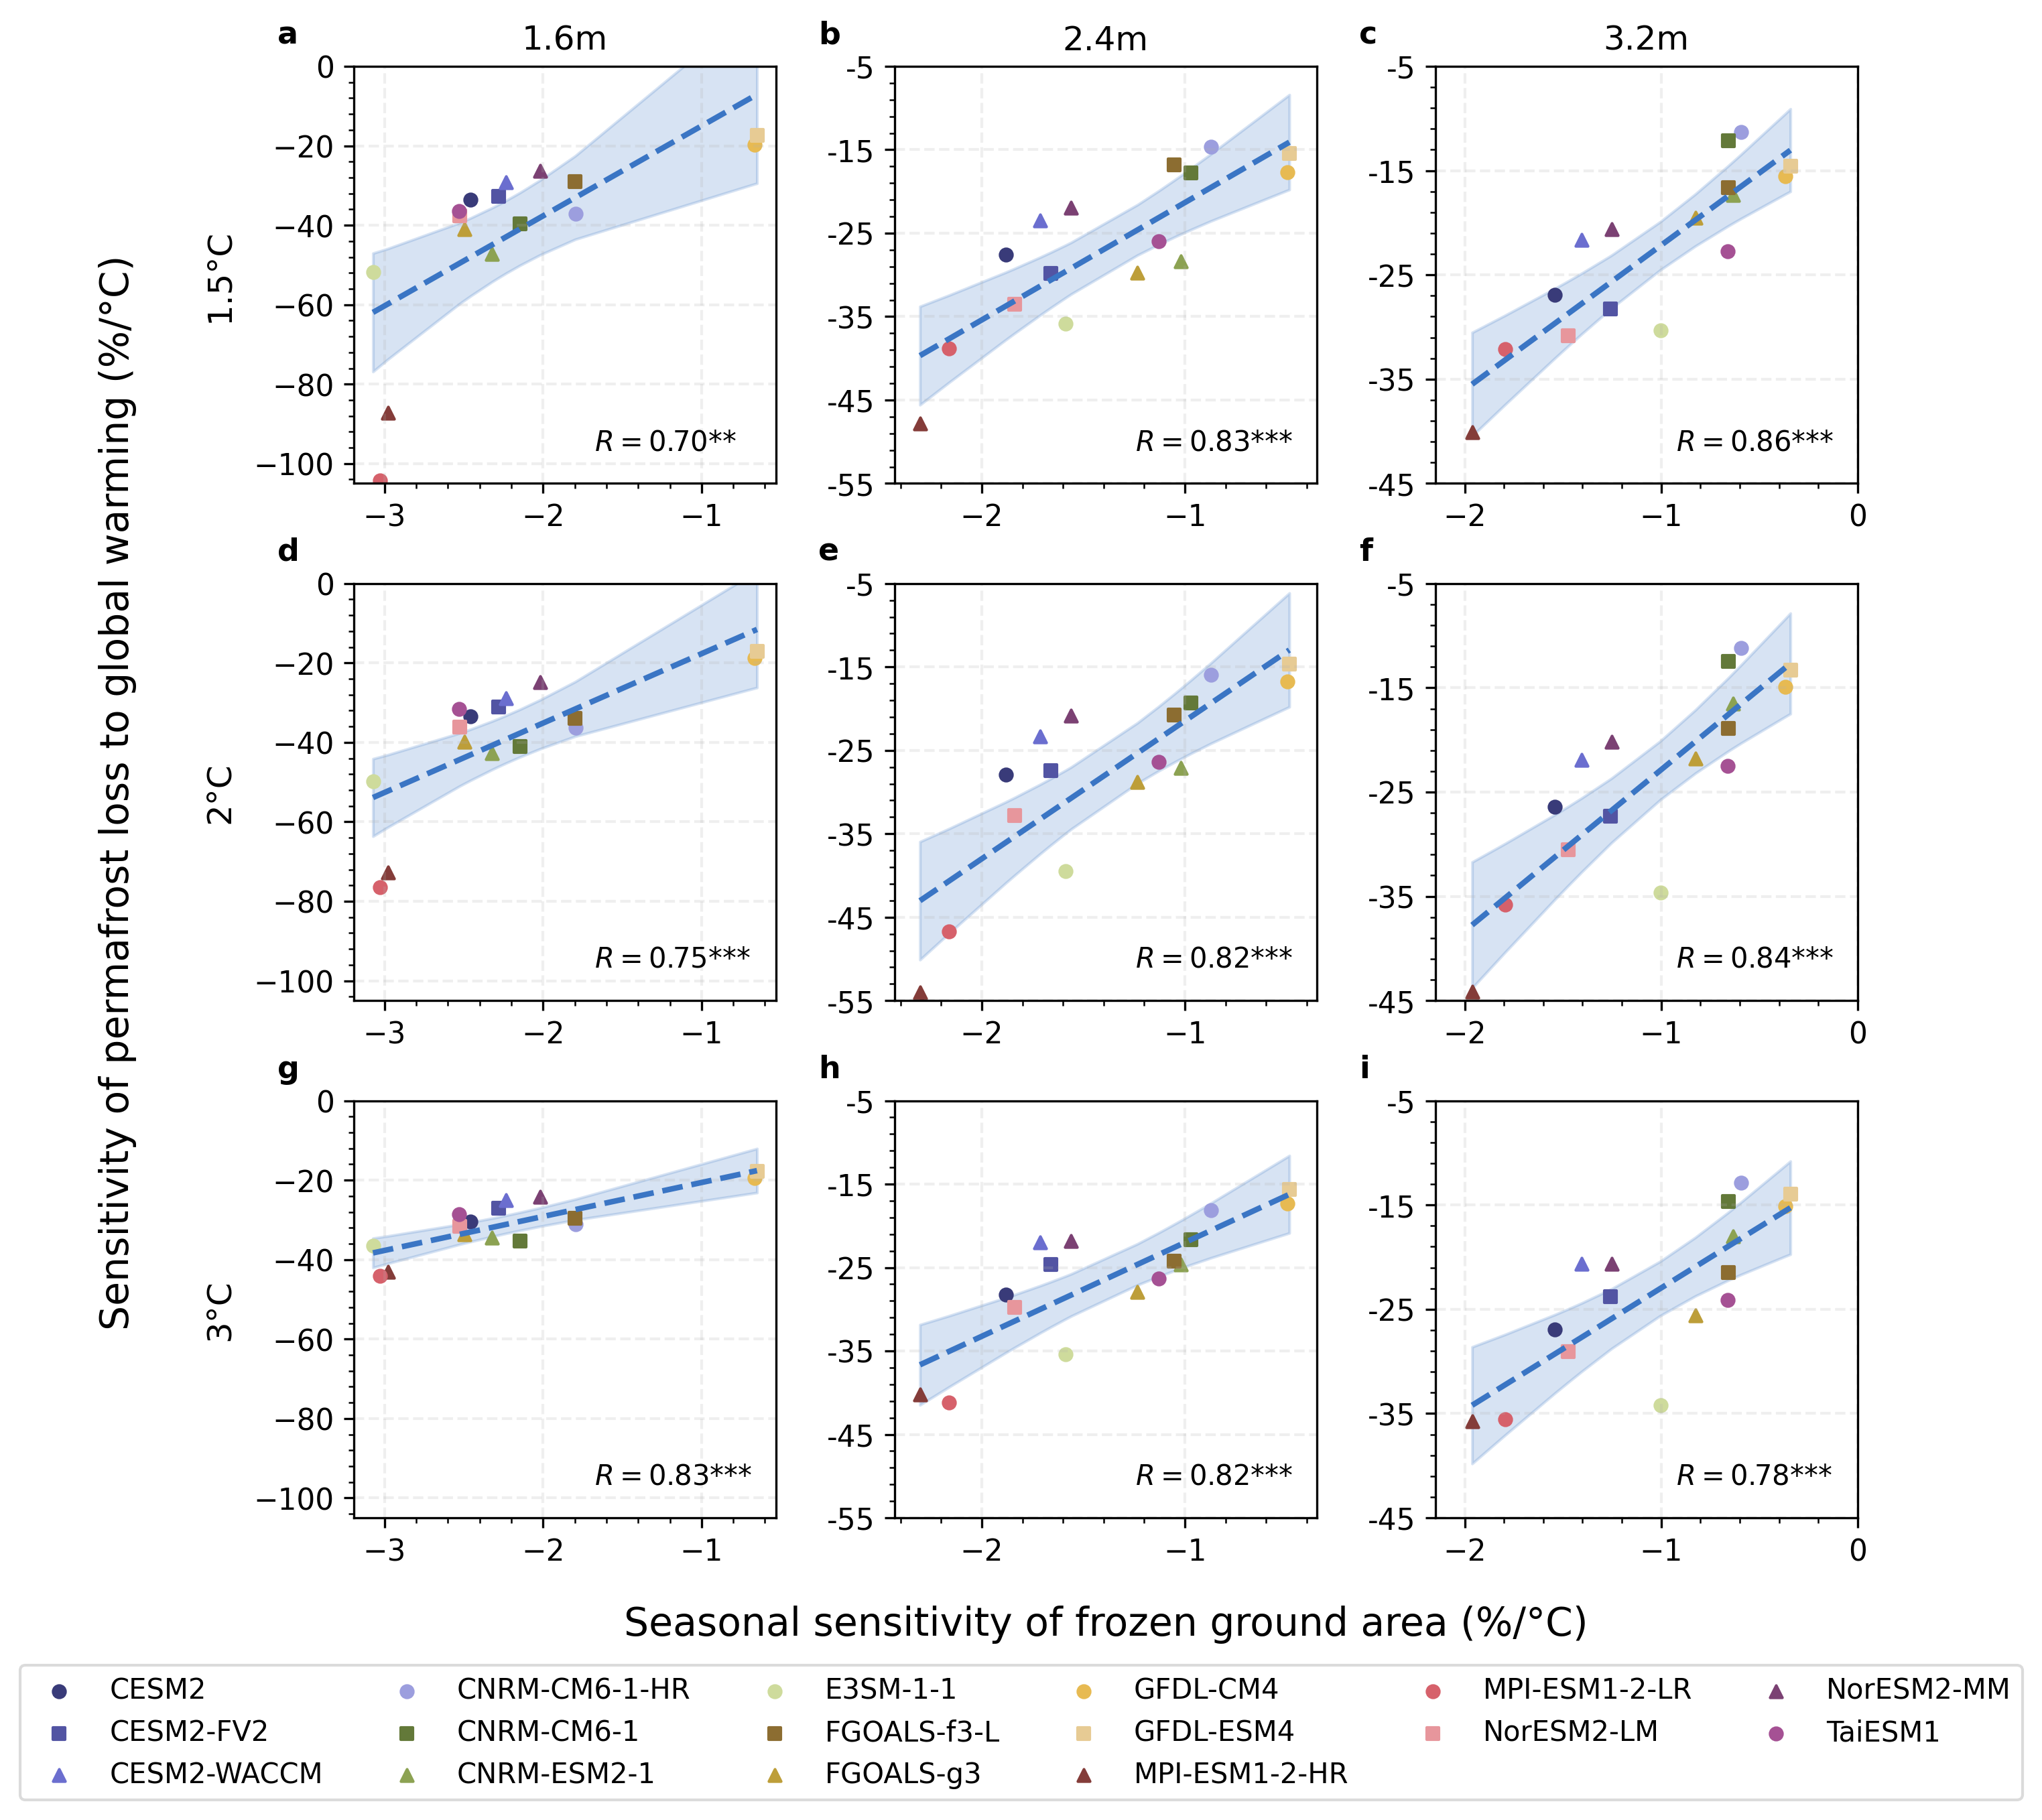

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(8.5, 9.5), dpi=300)
fig.subplots_adjust(wspace=0.28, hspace=0.24) 

# Initialize counter for plotting
a = 0
models = [ "CESM2", "CESM2-FV2", "CESM2-WACCM","CNRM-CM6-1-HR",
               "CNRM-CM6-1", "CNRM-ESM2-1", "E3SM-1-1", "FGOALS-f3-L", "FGOALS-g3", "GFDL-CM4", "GFDL-ESM4",
                "MPI-ESM1-2-HR", "MPI-ESM1-2-LR", "NorESM2-LM", "NorESM2-MM", "TaiESM1"]
begin = 1982
end = 2014
nyears = end - begin +1
for depth in [1.6,2.4,3.2]:
    # Load the permafrost probability data for the given depth
    q = xr.open_dataset('../Data/Probability_pf/probability_lt_threshold_'+str(int(depth*100))+'.nc')
    per_extent = q['probability_lt_threshold'][:,:360] # longitude limited to 0-180° Eurasian continent portion

    # Initialize DataFrames to store seasonal sensitivity of frozen ground area for each year
    seasonal_pf = pd.DataFrame(columns = ['year'])
    for i in range (nyears): # Years
        seasonal_pf.loc[i] = i + begin

    # Store the seasonal sensitivity of frozen ground area for each model (multi-year mean)
    means_df = pd.DataFrame(columns=['Model', 'x_mean'])
    
    for i in range(len(models)):
        modelname = models[i]        
        
        #---------------------------------------------------------------------------------------------------------------------------------------
        #                Calculate seasonal sensitivity of frozen ground area
        #---------------------------------------------------------------------------------------------------------------------------------------
        
        seasonal_pf[modelname] = ''
        # Load and process the area
        pfarea_file = "../Data/Permafrost_area_timeseries_ssp585/cmip6_alt"+str(int(depth*100))+"cm_NH45_EA0_180_pfarea_1850_2100_monthly/"+modelname+"_pfarea_NH45_1850_2100monthly.nc"
        pfarea_file2 = "../Data/Permafrost_area_timeseries_ssp585/cmip6_alt"+str(int(depth*100))+"cm_NH45_EA350_360_pfarea_1850_2100_monthly/"+modelname+"_pfarea_NH45_1850_2100monthly.nc"
        pfarea1 = Dataset(pfarea_file)['pfarea'][12*(begin-1850):12*(begin-1850)+12*nyears]/10**12 #1982-2014 EA0-180
        pfarea2 = (Dataset(pfarea_file2)['pfarea'][12*(begin-1850):12*(begin-1850)+12*nyears]/10**12).filled(np.nan) #1982-2014 EA350-360, many models simulate this area as 0 (NaN)
        
        # Calculate each year's permafrost area
        pf1 = pd.DataFrame(columns = ['year','month'])
        nmonth = 12 * nyears
        for j in range (nmonth):
            pf1.loc[j] = int(j/12)+begin
            pf1.month.loc[j] = j%12+1
        pf1[modelname] = np.nansum([pfarea1,pfarea2], axis=0)
        dfyears = pf1.groupby(['year'])
        dfyear = [dfyears.get_group(x) for x in dfyears.groups]

        # Load temperature data for seasonal calculations
        ts_file = glob.glob("/home/wangjx/Data/cmip6_tsl_05_depth_interpolated/" + modelname+"_*.nc")[0]
        f = xr.open_dataset(ts_file,decode_times=False)
        lat = f["lat"]
        lon = f["lon"][:360]
        tsl = f['tsl'][:,1,:,:360] # 0.2m Ts

        # Using 0.2m soil temperature tsl_sea_fg_area[time,lat,lon] 
        tsl_sea_fg_area = np.where(per_extent == 1, np.nan, tsl[:,:,:]) # mask 0.2m Ts where there's completely continuous permafrost
        tsl_sea_fg_area_means = np.array([area_weight_mean(tsl_sea_fg_area[t,:,:], lat.data, lon.data) for t in range(np.shape(tsl_sea_fg_area)[0])])
        
        # Calculate year by year
        for k in range(len(dfyear)):
            minmonth = dfyear[k].idxmin(axis = 0)[2]   # Find the index of the month with minimum permafrost area in a year
            maxmonth = dfyear[k].idxmax(axis = 0)[2]   # Find the index of the month with maximum permafrost area in a year
            tsl_annualmax = tsl_sea_fg_area_means[k*12:k*12+12].max()   # Highest 0.2 mTs in a year
            tsl_annualmin = tsl_sea_fg_area_means[k*12:k*12+12].min()   # Lowest 0.2 mTs in a year
            
            # Percentage of seasonal variation in permafrost area / seasonal variation in 0.2m soil temperature
            seasonal_pf[modelname].loc[k] = (dfyear[k].loc[minmonth,:][modelname]-dfyear[k].loc[maxmonth,:][modelname])/dfyear[k].loc[maxmonth,:][modelname]*100/(tsl_annualmax-tsl_annualmin)
        
        # Calculate muti-year mean, store mean values for plotting
        new_row = pd.DataFrame([{'Model': modelname, 'x_mean': np.nanmean(seasonal_pf[modelname])}])    
        means_df = pd.concat([means_df, new_row], ignore_index=True)

    #---------------------------------------------------------------------------------------------------------------------------------------
    #                  Permafrost sensitivity to global warming
    #---------------------------------------------------------------------------------------------------------------------------------------

    file_path = "../Data/Permafrost_sensitivity/" + str(int(depth*100)) + "cm_permafrost_sensitivity_under_climate_change_ssp585.csv"  # unit: %/℃
    pfarea_dt = pd.read_csv(file_path).set_index('model').loc[models]
    pfarea_dt3, pfarea_dt2, pfarea_dt15 = pfarea_dt['3'], pfarea_dt['2'], pfarea_dt['1.5']
    
    # Skip excluded models
    midx = np.array([
        model != "CanESM5" and model != "CanESM5-CanOE" and model != "IPSL-CM6A-LR"
        and model != "CAS-ESM2-0" and model != "CMCC-CM2-SR5" and model != "CMCC-ESM2"
        and model != "MIROC-ES2L" and model != "MIROC6"
        for model in models
    ])

    means_df.set_index('Model', inplace=True)
    means_df = means_df.loc[models]
    means_df.reset_index(inplace=True)   
    
    #---------------------------------------------------------------------------------------------------------------------------------------
    #  Plot seasonal sensitivity of frozen ground area and long-term sensitivity of permafrost loss to global warming
    #---------------------------------------------------------------------------------------------------------------------------------------

    for i, pfarea in enumerate([pfarea_dt15, pfarea_dt2, pfarea_dt3]):
        plot_sensitivity(means_df['x_mean'][midx], 
                         pfarea[midx], models, i, a)
    a += 1

# Adjust layout and show plot
plt.subplots_adjust(left=0.1, right=0.98,bottom=0.2, top=0.96) 

In [ ]:
fig.savefig("../Figures/FigureS4.png", bbox_inches='tight',dpi=300)